In [1]:
import rebound
import reboundx
import numpy as np
from collections import OrderedDict
from numpy.random import seed, normal, uniform
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('./')

from ic import wrap, output, plot, removedamping, integrate, initialize, drawnormal, res_chain_setup

In [2]:
incdist = {'b':[89.65,0.27], 'c':[89.67, 0.17], 'd':[89.75,0.16], 'e':[89.86, 0.12], 'f':[89.68,0.034], 'g':[89.710,0.025], 'h':[89.8, 0.3]}
for inc in incdist.values():
    inc[0] = (90-inc[0])*np.pi/180.
    inc[1] *= np.pi/180.

    massdist = {'b':[0.85,0.72], 'c':[1.38,0.61], 'd':[0.41,0.27], 'e':[0.62,0.58], 'f':[0.68,0.18], 'g':[1.34,0.88], 'h':[0.41, 0.27]}
Mearth = 3.e-6
Mstar = 0.08
for mass in massdist.values():
    mass[0] *= Mearth/Mstar
    mass[1] *= Mearth/Mstar

In [9]:
massdist

{'b': [3.1875e-05, 2.7000000000000002e-05],
 'c': [5.175e-05, 2.2875e-05],
 'd': [1.5375e-05, 1.0125000000000002e-05],
 'e': [2.3250000000000003e-05, 2.175e-05],
 'f': [2.5500000000000003e-05, 6.750000000000001e-06],
 'g': [5.025000000000001e-05, 3.3e-05],
 'h': [1.5375e-05, 1.0125000000000002e-05]}

In [26]:
planets = ['d', 'e', 'f', 'g', 'h']
resonances = OrderedDict([(('d','e'),(3,2)),(('e','f'),(3,2)),(('f','g'),(4,3)),(('g','h'),(3,2))]) # ordered so we add planets in right sequence
threebodyresonances = OrderedDict([(('d','e','f'),(2,3)),(('e','f','g'),(1,2)),(('f','g','h'),(1,1))])

simID=3
seed(simID)
K = 10**uniform(1,3)
print(K)

126.3559813738166


/mnt/raid-cita/dtamayo/p3new/lib/python3.4/site-packages/rebound/simulation.py:507: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 4.62 s, sys: 0 ns, total: 4.62 s
Wall time: 4.62 s


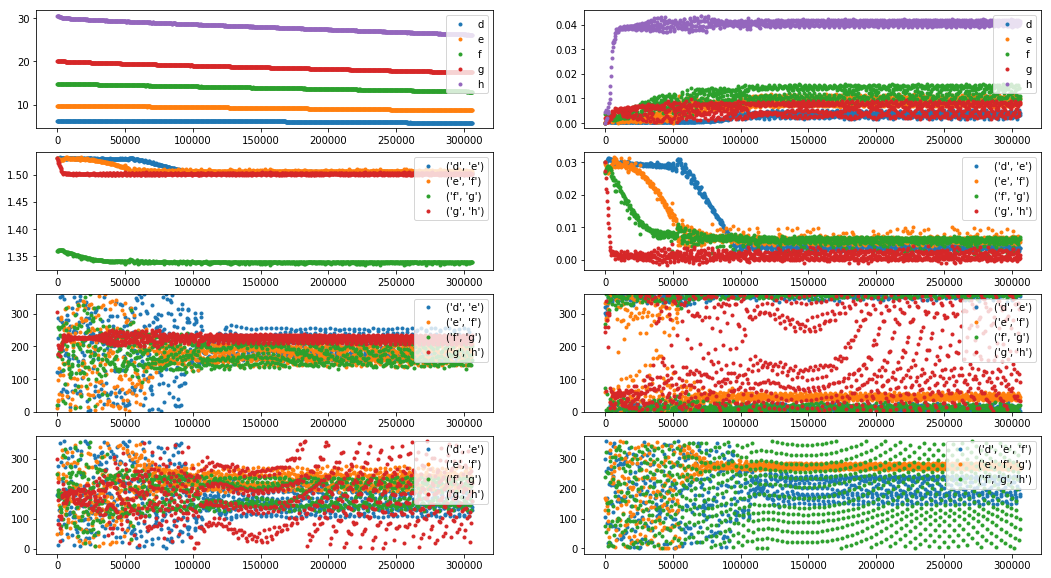

In [27]:
%%time
sim = rebound.Simulation()
ps = sim.particles

rebx = reboundx.Extras(sim)
params = rebx.add("modify_orbits_forces")

delta=2.e-2 # fractional distance to start beyond resonance. Would be better to calculate relative to width of resonance

res_chain_setup(sim, planets, resonances, delta, massdist, incdist)

sim.integrator="whfast"
sim.dt=ps[1].P*0.07

outputs = initialize(planets, resonances, threebodyresonances)

taua = 1.e4*ps[-1].P
taue = taua/K

for p in ps[1:]:
    p.params["tau_e"] = -taue
ps['h'].params["tau_a"] = -taua

T = taua*delta*50
Nout = 1000

times = np.linspace(sim.t,sim.t+T,Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    output(sim,planets,resonances,threebodyresonances,outputs)
plot(planets,resonances,threebodyresonances,outputs);

In [16]:
for p in ps[1:]:
    print(p.P)

6.283124023458428
9.6131797558914
14.708165026513838
20.003104436058774
30.604749787169933


/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


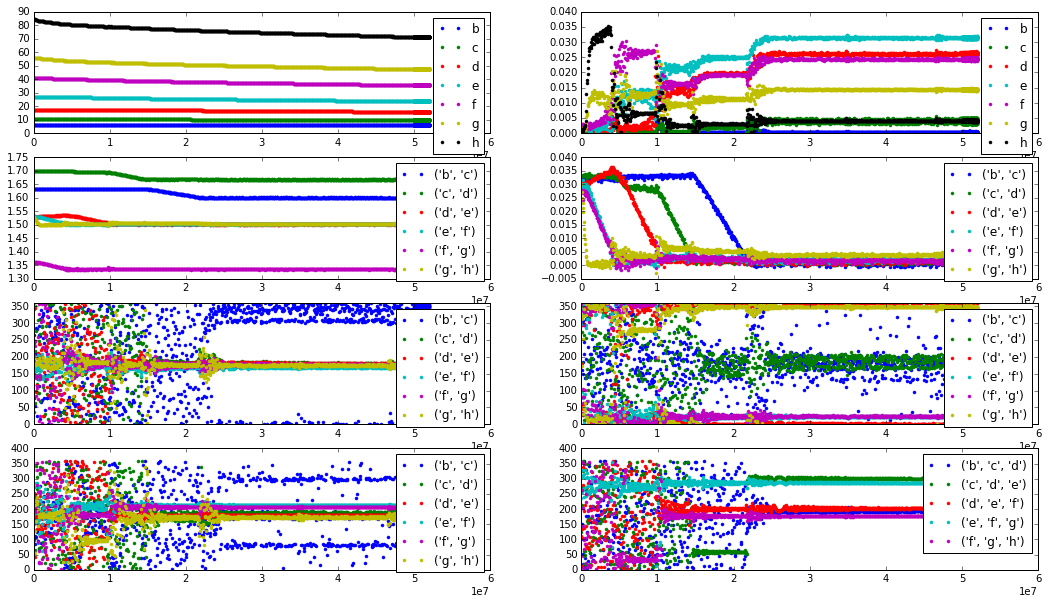

In [5]:
Tremoval = 5 # number of taue0s over which to remove damping
removedamping(sim, Tremoval, K, planets,resonances,threebodyresonances,outputs)
plot(planets,resonances,threebodyresonances,outputs);

In [6]:
sim.save("7p.bin")

In [9]:
sim = rebound.Simulation.from_file("7p.bin")

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:375: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [10]:
from numpy.testing import assert_approx_equal
seed(simID)
assert_approx_equal(K, 10**uniform(1,3), 4, "simID did not generate same value of K as in ic") # get next random number after K to match up with selectic scripts
mag = 10**uniform(-3,0)
print(mag)

sim2 = rebound.Simulation()
sim2.G = 4*np.pi**2
sim2.add(m=Mstar)

Pd = 4.0496/365.25

mscale = Mstar/sim.particles[0].m
Pscale = Pd/sim.particles['d'].P

ps = sim.particles
for p in planets: 
    r = uniform(-1,1)
    sign = abs(r)/r # get +/- 1 randomly
    sim2.add(m=ps[p].m*mscale, P=ps[p].P*Pscale, e=ps[p].e*(1. + sign*mag), inc=ps[p].inc, pomega=ps[p].pomega, Omega=ps[p].Omega, theta=ps[p].theta, hash=p)

sim2.move_to_com()

0.13981961408994042


In [11]:
sim = sim2
ps = sim.particles
sim.integrator="whfast"
sim.dt=ps[1].P*0.07

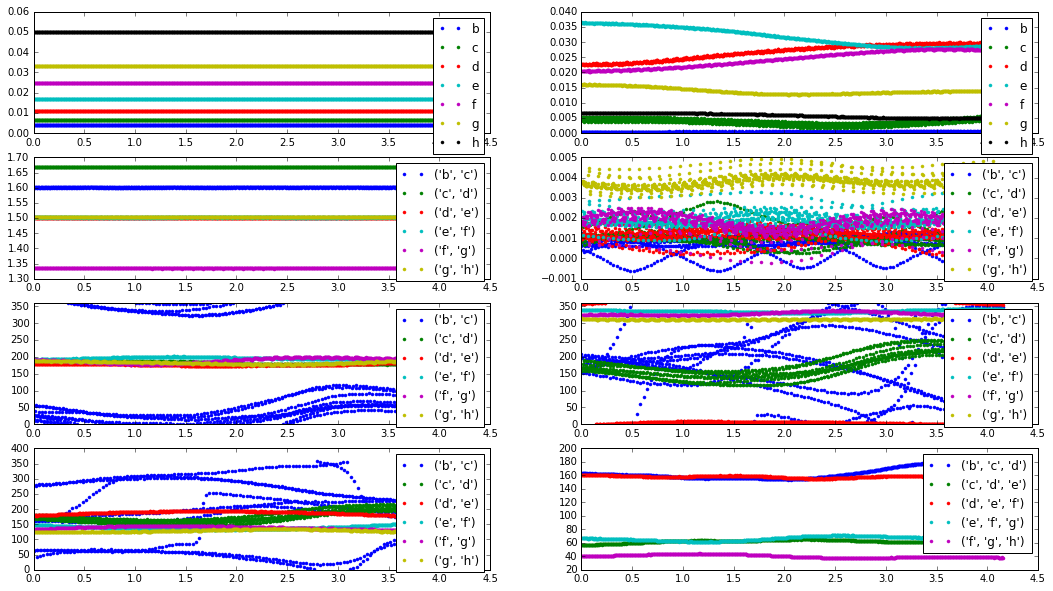

In [12]:
outputs = initialize(planets, resonances, threebodyresonances)
  
integrate(sim, 1.e3*ps[1].P, planets, resonances, threebodyresonances,outputs)
plot(planets,resonances,threebodyresonances,outputs);

In [13]:
sim.status()

---------------------------------
REBOUND version:     	3.2.3
REBOUND built on:    	Mar  7 2017 21:51:15
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	4.153276
Current timestep:    	0.000291
---------------------------------
<rebound.Particle object, m=0.08 x=-1.761288462385224e-07 y=-3.3959828523311533e-06 z=9.320279212959998e-09 vx=0.0006987775433643334 vy=-0.0006528616881888585 vz=-9.546897396531187e-06>
<rebound.Particle object, m=4.151838160147789e-06 x=0.005714083139790234 y=-0.00955493517608129 z=1.3256074475707495e-05 vx=14.459777855084358 vy=8.644302108702272 vz=0.20503503133371334>
<rebound.Particle object, m=2.5978149814924043e-06 x=0.00821732115754044 y=0.012780944041755298 z=-6.91394931178541e-05 vx=-12.109716223610556 vy=7.852411761588977 vz=0.08833145723421766>
<rebound.Particle object, m=2.2555560091848006e-06 x=0.006128966444026983 y=0.02086642055952155 z=4.649938104824447e-05 vx=-11.552516004292105 vy=3.0830300276096234 vz=-0.0772781005776

In [41]:
sim.save("dissipationscaling.bin")